In [2]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from multiprocessing import Queue
from multiprocessing import Process
from Bio.Seq import Seq
from Bio import SeqIO
from multiprocessing import Pool, freeze_support

/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pitikovegor/anaconda/anaconda/lib/pyt

# Info about paths

In [22]:
cell_type = 'K562'
experiment = 'GSM4041595_K562_rep2.hg38'
k = 4

In [23]:
cont_data_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)
sequence_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/chr_sequence'


chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

# Count kmers and make sets

In [24]:
params = {'pval_trash_good': 0.05,
          'pval_trash_bad': 0.1,
          'rna_count_trash':  900,
          'cont_count_trash': 0,
          'zscore_trash_good': 0,
          'zscore_trash_bad_max': 1,
          'zscore_trash_bad_min': -1,}

In [25]:
#extract k-mers
def seq_cutter(sequence, position, chain):
    if chain=='+':
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq
    
def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3])
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 4:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(5+4**k)))
            

In [26]:
def make_sets (contact_data_table, redc_table, params):
    contacts = pd.read_table(contact_data_table, sep='\t')
    #print(')')
    #print(set(contacts['pval']))
    #contacts = contacts[contacts['pval'] != 'False']
    #print('))')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_table(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'is_translate', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner').drop_duplicates()
    del redc
    contacts = contacts[contacts['is_translate']==0].reset_index()
    contacts['class'] = 0
    conditions = [
        (contacts['pval'] <= params['pval_trash_good']) &
        (contacts['rnaseq_count'] >= params['rna_count_trash']) &
        (contacts['zscore'] >= params['zscore_trash_good']) &
        (contacts['contacts_count'] >= params['cont_count_trash']) #&
        #(contacts['gene_type'] in params['class_trash_good'])
     ]
    values = [1]
    #print(np.count_nonzero(np.select(conditions, values) == 1), table1, contact_data_table)
    contacts['class'] = pd.Series(np.select(conditions, values))
    #k_mers = sequence_process_rna(sequence, k, contacts[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'class']])
    #result_table = pd.merge(left=contacts, right=k_mers, left_on='id', right_on=0, how ='inner')
    return contacts

In [27]:
def all_tables(chr_seq, contact_data_table, redc_table, params, k):
    #print('start')
    chr_cont = make_sets(contact_data_table,  redc_table, params)
    #print('read first table')
    true_positive = chr_cont[(chr_cont['class']==1) & (chr_cont['dna_chr']!=chr_cont['rna_chr'])]
    true_positive = true_positive[true_positive['rna_chr']!= true_positive['dna_chr']]
    true_positive = true_positive.sample(n = min(len(true_positive['class']), 50000))
    true_negative = chr_cont[(chr_cont['pval']>=params['pval_trash_bad']) & (chr_cont['dna_chr']!=chr_cont['rna_chr'])]
    true_negative = true_negative[(true_negative['rna_chr']!= true_negative['dna_chr']) & (true_negative['gene_type'] == 'protein_coding')]
    true_negative = true_negative.sample(n = min(len(true_negative['class']), len(true_positive['class'])*5))
    del chr_cont
    kmers_positive = sequence_process_rna(chr_seq, k, true_positive[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'class']])
    kmers_negative = sequence_process_rna(chr_seq, k, true_negative[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'class']])
    return true_positive, true_negative, kmers_positive, kmers_negative  

In [8]:
all_proc = Pool(processes = 24)
#all_data.close()
all_data = all_proc.starmap(all_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), params, k) for i in chr_names])
all_proc.close()
all_proc.join()

In [9]:
all_contacts = pd.concat([i[0] for i in all_data] + [i[1] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[2] for i in all_data] + [i[3] for i in all_data], ignore_index = True)

In [10]:
all_kmers

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,259,260
0,D00795:30:CA2UTANXX:5:1307:17336:92847,2256412,2256509,+,1,0,0,0,0,0.003367,...,0,0.0117845,0,0.00841751,0.010101,0.003367,0.0016835,0.0151515,0.003367,0.00505051
1,D00795:30:CA2UTANXX:5:2110:8965:19325,2251303,2251356,+,1,0,0,0.00181818,0,0,...,0.00181818,0.00909091,0.00545455,0.00181818,0.00363636,0.00363636,0.00545455,0.00727273,0.00363636,0.0109091
2,D00795:30:CA2UTANXX:1:1107:7462:7957,2243559,2243646,+,1,0,0.00342466,0.00171233,0,0.00342466,...,0,0.010274,0,0.00684932,0.00684932,0.010274,0.00171233,0.00513699,0.00513699,0.00171233
3,D00795:30:CA2UTANXX:1:1101:16949:7547,2243683,2243768,+,1,0.00171821,0.00515464,0.00343643,0,0.00343643,...,0,0.0171821,0.00171821,0.00515464,0.00687285,0.0103093,0.00343643,0.0137457,0.00687285,0.0120275
4,D00795:30:CA2UTANXX:5:2204:7721:97019,2250660,2250761,+,1,0.00167224,0.00167224,0.00167224,0.00167224,0,...,0,0.0083612,0.00334448,0.0083612,0.0100334,0,0.00334448,0.00501672,0.0117057,0.0133779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774715,D00795:30:CA2UTANXX:1:1306:4550:66559,28889987,28890037,+,0,0.00365631,0.00365631,0.00731261,0.00731261,0.00365631,...,0,0.00731261,0.0109689,0.00548446,0.00731261,0.00548446,0.00731261,0.00731261,0.00731261,0.0109689
774716,D00795:30:CA2UTANXX:1:2307:1694:74565,21778702,21778793,-,0,0.00170068,0.00170068,0.00170068,0.00340136,0.00170068,...,0,0.00680272,0.00340136,0.00510204,0.00340136,0.00340136,0.00340136,0.00510204,0.00510204,0.0187075
774717,D00795:30:CA2UTANXX:5:2306:18946:20012,27865696,27865784,-,0,0.00512821,0.00512821,0.00854701,0.0034188,0.00683761,...,0,0.00683761,0.00512821,0.0136752,0.0102564,0.0119658,0.0153846,0.00683761,0.0239316,0.0410256
774718,D00795:30:CA2UTANXX:1:1306:10830:29549,23183187,23183244,+,0,0.00361011,0.00361011,0.00180505,0.00361011,0,...,0,0.00902527,0.00722022,0.00722022,0.0108303,0.00722022,0,0.00722022,0.0216606,0.0216606


In [11]:
all_contacts

,index,Unnamed: 0,chr,id,gene,gene_ac,contacts_count,rnaseq_count,zscore,pval,...,is_translate,rna_chr,rna_bgn,rna_end,dna_bgn,dna_end,dna_chr,rna_strand,dna_strand,class
0,1535742,1503928,chr1,D00795:30:CA2UTANXX:5:1307:17336:92847,SKI,ENSG00000157933.10,10618,1011,1.985521,0.047087,...,0,chr1,2256412,2256509,133684006,133684029,chr9,+,+,1
1,1536190,1504376,chr1,D00795:30:CA2UTANXX:5:2110:8965:19325,SKI,ENSG00000157933.10,10618,1011,1.985521,0.047087,...,0,chr1,2251303,2251356,22752121,22752144,chr5,+,+,1
2,1531470,1499656,chr1,D00795:30:CA2UTANXX:1:1107:7462:7957,SKI,ENSG00000157933.10,10618,1011,1.985521,0.047087,...,0,chr1,2243559,2243646,113230617,113230640,chr11,+,+,1
3,1531223,1499409,chr1,D00795:30:CA2UTANXX:1:1101:16949:7547,SKI,ENSG00000157933.10,10618,1011,1.985521,0.047087,...,0,chr1,2243683,2243768,26986405,26986428,chr5,+,+,1
4,1536436,1504622,chr1,D00795:30:CA2UTANXX:5:2204:7721:97019,SKI,ENSG00000157933.10,10618,1011,1.985521,0.047087,...,0,chr1,2250660,2250761,4268427,4268451,chr9,+,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774715,476653,476653,chr22,D00795:30:CA2UTANXX:1:1306:4550:66559,ZNRF3,ENSG00000183579.16,10407,1592,1.557408,0.119374,...,0,chr22,28889987,28890037,23614528,23614552,chr7,+,-,0
774716,211530,202166,chr22,D00795:30:CA2UTANXX:1:2307:1694:74565,MAPK1,ENSG00000100030.15,30378,16785,0.397350,0.691110,...,0,chr22,21778702,21778793,130823705,130823729,chr9,-,+,0
774717,288189,279466,chr22,D00795:30:CA2UTANXX:5:2306:18946:20012,PITPNB,ENSG00000180957.18,6701,3092,0.560059,0.575439,...,0,chr22,27865696,27865784,71124214,71124237,chr13,-,+,0
774718,51842,44517,chr22,D00795:30:CA2UTANXX:1:1306:10830:29549,BCR,ENSG00000186716.21,22647,6690,0.963126,0.335484,...,0,chr22,23183187,23183244,1645065,1645088,chr12,+,-,0


# Training

In [12]:
good_contacts = all_kmers[all_kmers[4]==1]
good_contacts = good_contacts.sample(n = min(len(good_contacts[0]), 100000))
bad_contacts = all_kmers[all_kmers[4]==0]
bad_contacts = bad_contacts.sample(n = min(len(good_contacts[0])*10, len(bad_contacts[0])))
all_set_contacts = good_contacts.append(bad_contacts, ignore_index = True)
del good_contacts
del bad_contacts
all_set_contacts = all_set_contacts.to_numpy()

In [13]:
data_train, data_test, label_train, label_test = train_test_split(all_set_contacts[:, 5:], all_set_contacts[:, 4], test_size=0.2, random_state=42)

In [14]:
dtrain = xgb.DMatrix(data_train, label=label_train)
dtest = xgb.DMatrix(data_test, label=label_test)

In [15]:
param = {
    'max_depth': 1000,
    'eta': 0.3, 
    'silent': 4, 
    'objective': 'multi:softprob',
    'num_class': 2,
    'nthread' : 16,
    'num_parallel_tree': 1,
    'eval_metrics': 'logloss',
    }
num_boost_round = 500

In [16]:
bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals = [(dtest, 'eva1')], early_stopping_rounds = 10)

trees = [s for s in bst]
assert len(trees) == num_boost_round

[08:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:48:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
q = 30
name = 'xgb_trans_%s_%s_%s' % (current_time, k, experiment)
bst.save_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s' % name)
bst.dump_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s_dump' % name, '/Users/pitikov_egor/Documents/CourseWork/genomes/models/features_%s' % name)
q+=1

In [24]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
precision_score(list(label_test), best_preds)

0.8667042484497515

In [25]:
fpr, tpr, thresholds = roc_curve(list(label_test), list(preds[:, 1]))

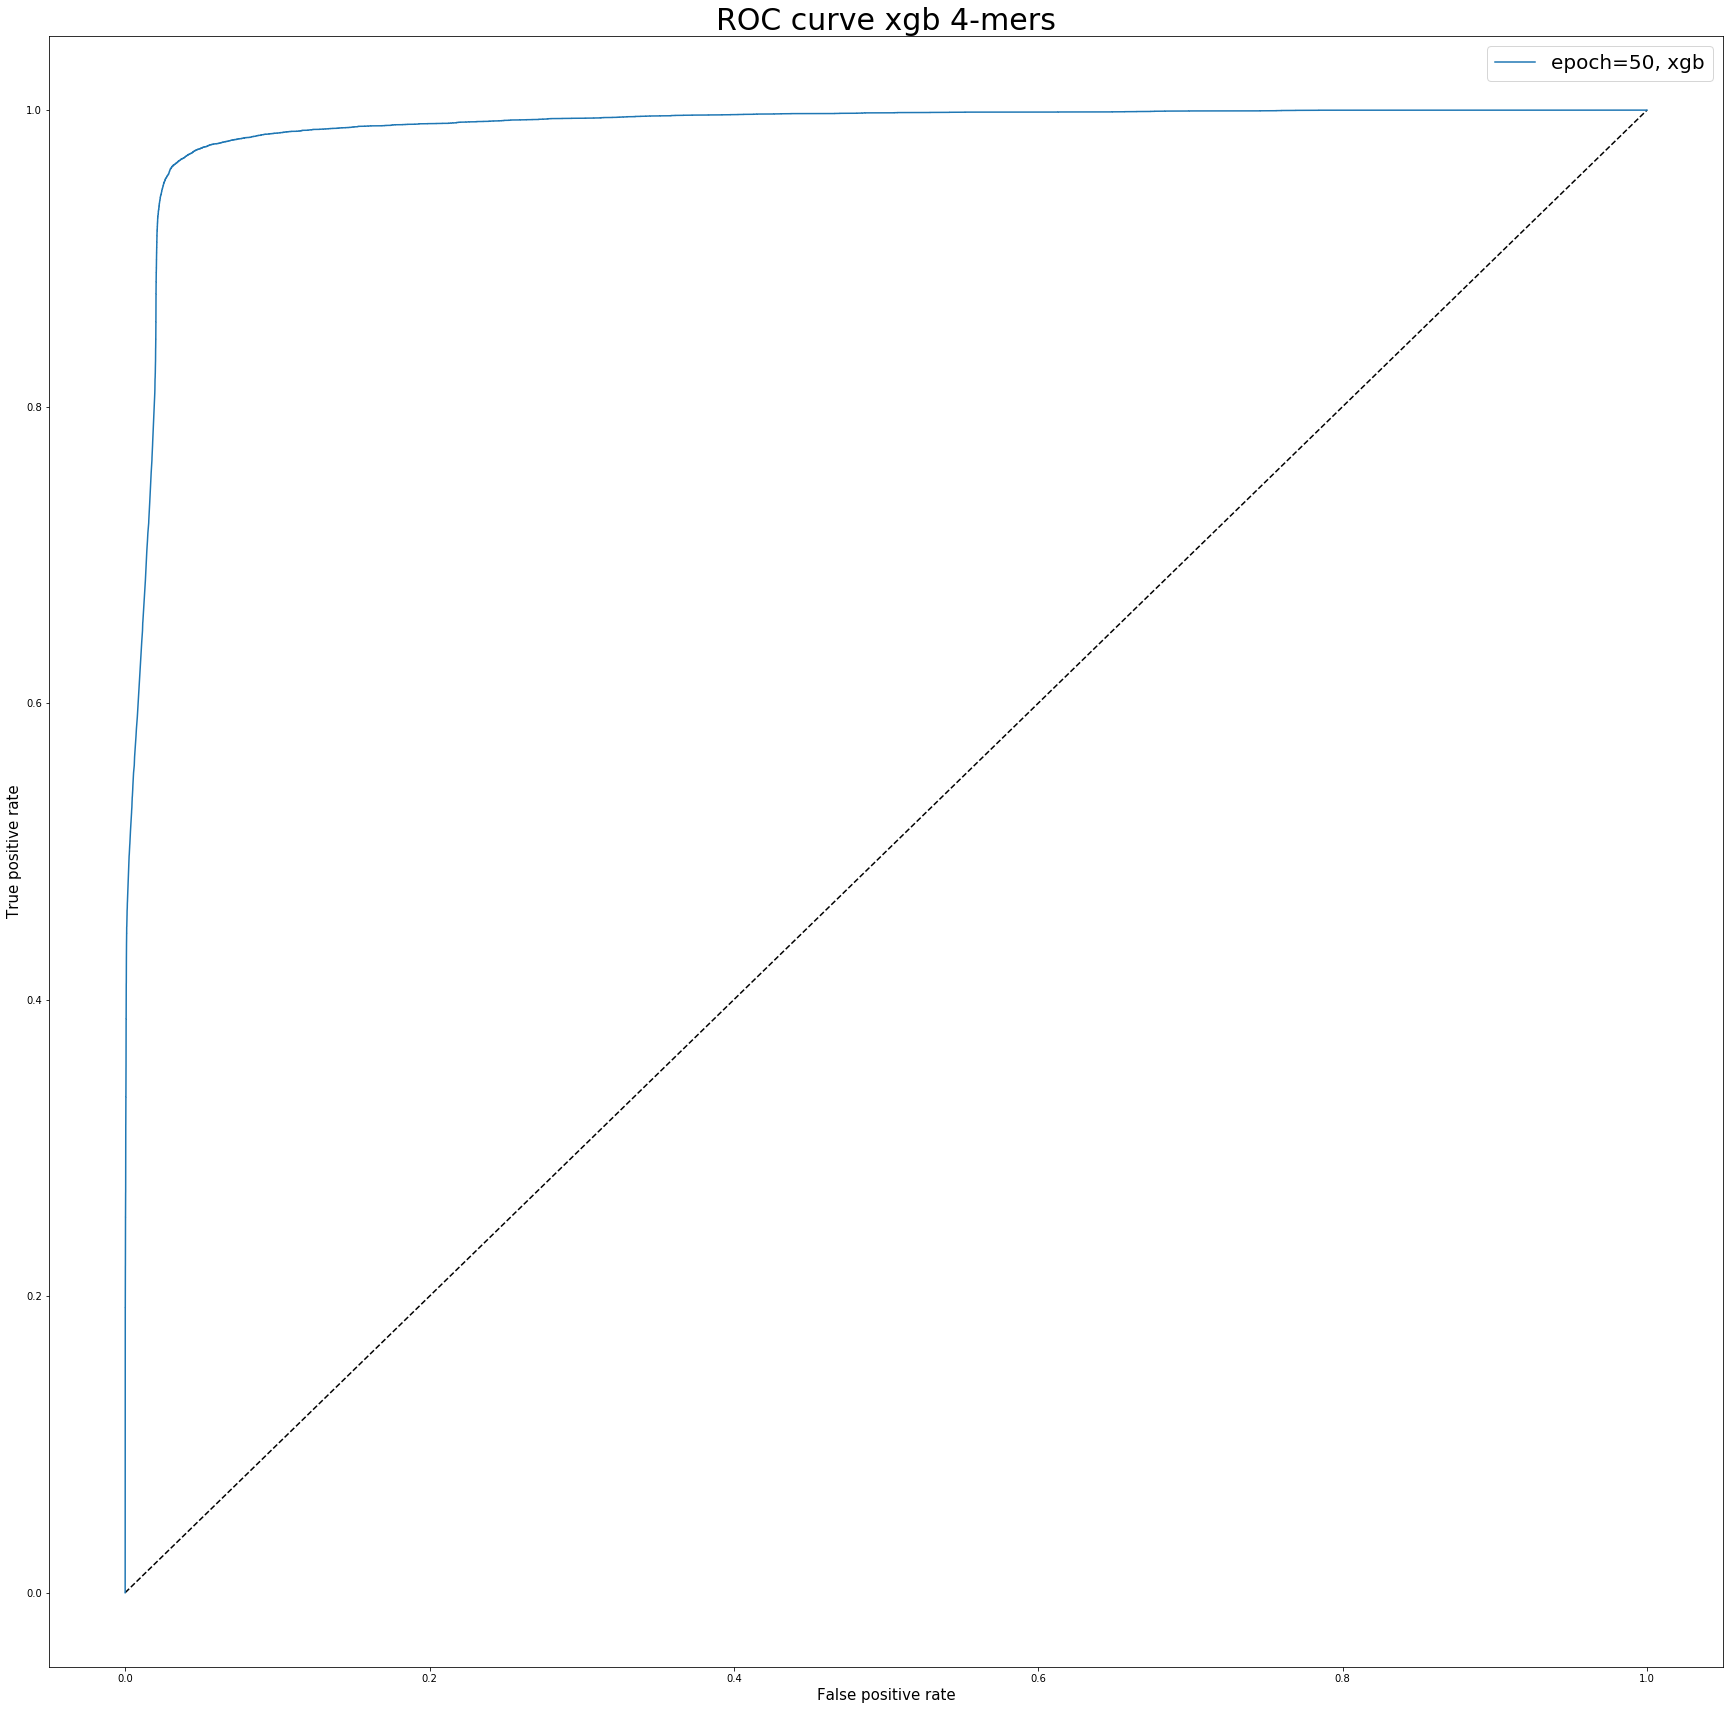

In [30]:
plt.figure(1, figsize=(30, 30))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='epoch=%s, xgb'%(num_boost_round))
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve xgb 4-mers', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.savefig('/Users/pitikov_egor/Documents/CourseWork/genomes/pictures/Models/%s_ROC.png' % name)
plt.show()

In [ ]:
del all_set_contacts

# Open and check

In [82]:
modelname = 'xgb_trans_15:17:46_GSM4041595_K562_rep2.hg38'

In [83]:
bst = xgb.Booster({'nthread': 10})
bst.load_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s.model' % modelname) 

In [84]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
cont_data_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)
sequence_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/chr_sequence'

In [85]:
def make_test_sets (contact_data_table, redc_table):
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_table(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'is_translate', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner')
    del redc
    contacts = contacts[contacts['is_translate']==0].reset_index()
    #contacts = contacts[contacts['rna_chr']!=contacts['dna_chr']]
    contacts['class'] = 0
    return contacts

In [86]:
def all_test_tables(chr_seq, contact_data_table, redc_table, k):
    chr_cont = make_test_sets(contact_data_table,  redc_table)
    kmer = sequence_process_rna(chr_seq, k, chr_cont[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'gene_type']])
    return chr_cont, kmer

In [87]:
all_proc_test = Pool(processes = 24)
all_data = all_proc_test.starmap(all_test_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), k) for i in chr_names])
all_proc_test.close()
all_proc_test.join()

In [88]:
all_contacts = pd.concat([i[0] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[1] for i in all_data], ignore_index = True)

In [89]:
all_kmers = all_kmers.to_numpy()
full_kmers = xgb.DMatrix(all_kmers[:, 5:])
preds = bst.predict(full_kmers)
best_preds = np.asarray([np.argmax(line) for line in preds])


In [90]:
best_preds
preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
gene_types = list(set(all_kmers[:, 4]))

In [91]:
means = {}
for i in gene_types:
    spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
    nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
    print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
    means[i] = [nonspec, spec]

miRNA have 0 specific and 54 nonspecific contacts
TEC have 0 specific and 297 nonspecific contacts
snRNA have 812 specific and 4480 nonspecific contacts
transcribed_unitary_pseudogene have 2 specific and 1022 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
transcribed_processed_pseudogene have 0 specific and 8470 nonspecific contacts
processed_pseudogene have 0 specific and 516 nonspecific contacts
transcribed_unprocessed_pseudogene have 0 specific and 5134 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
unprocessed_pseudogene have 0 specific and 455 nonspecific contacts
unitary_pseudogene have 0 specific and 5 nonspecific contacts
snoRNA have 0 specific and 4915 nonspecific contacts
IG_V_gene have 0 specific and 3 nonspecific contacts
lncRNA have 2373 specific and 205347 nonspecific contacts
protein_coding have 2790 specific and 1016469 nonspecific contacts
scaRNA have 0

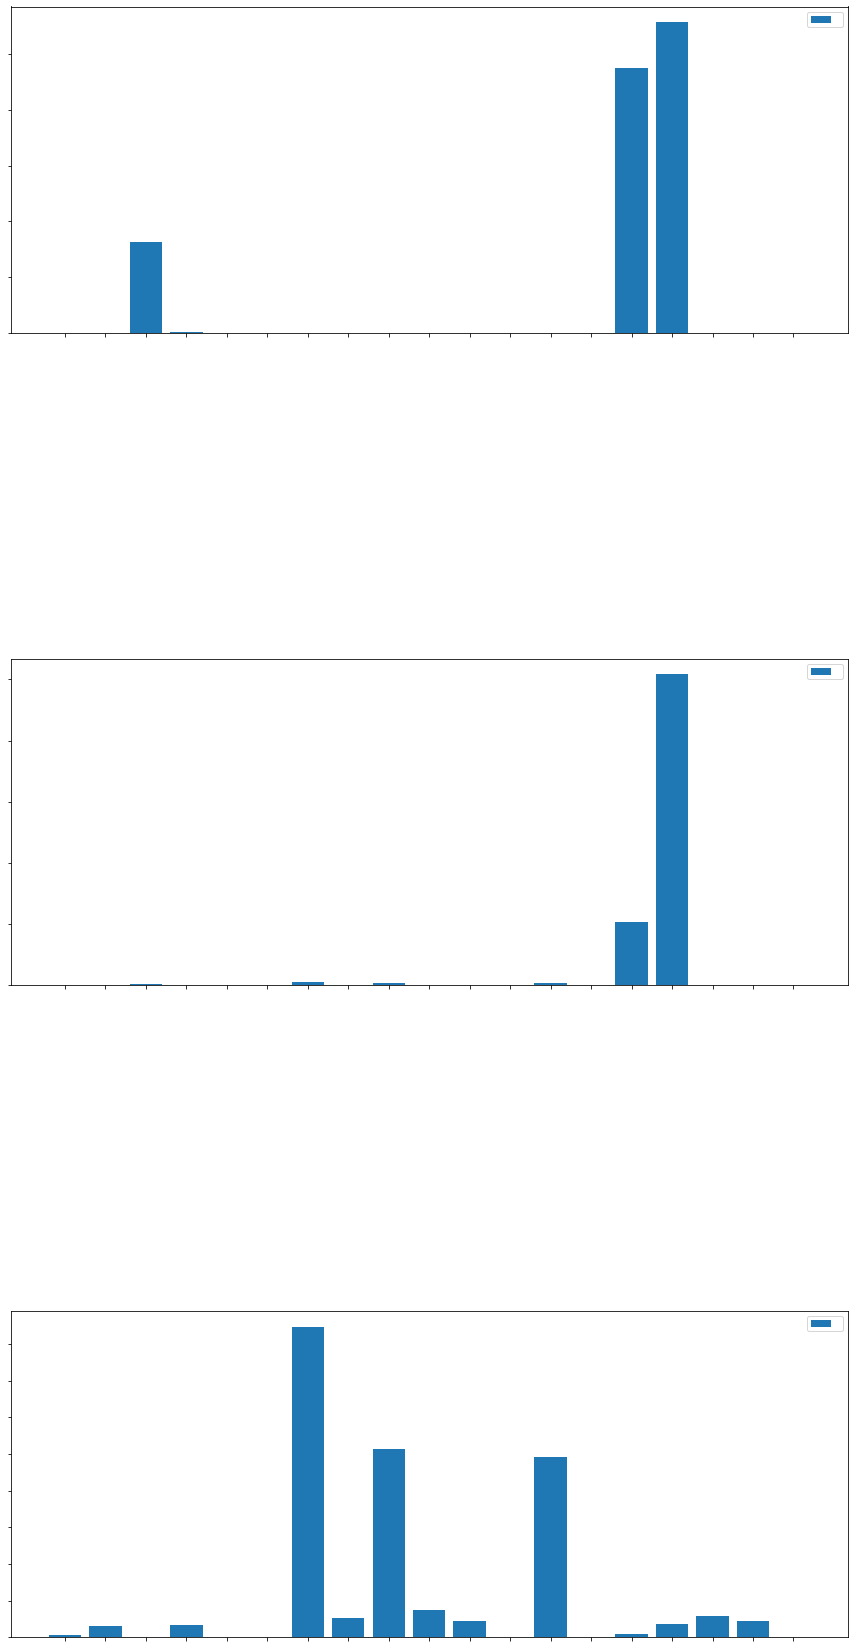

In [92]:
plt.rcParams['axes.titlesize'] = 8
fig = plt.figure(1, figsize=(15, 30))
gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, :])
spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], label='specific')
ax0.set_ylabel('Number')
ax0.set_title('Specific by classes', fontsize=20)
ax0.set_xticks(np.arange(len(means.keys()))) 
ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1, :])
nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], label='nonspecific')
ax1.set_ylabel('Number')
ax1.set_title('Nonspecific by classes', fontsize=20)
ax1.set_xticks(np.arange(len(means.keys())))
ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax1.legend()
ax2 = fig.add_subplot(gs[2, :])
nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], label='nonspecific/specific')
ax2.set_ylabel('Number')
ax2.set_title('Nonspecific/specific by classes', fontsize=20)
ax2.set_xticks(np.arange(len(means.keys())))
ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax2.legend()
plt.subplots_adjust(wspace=2, hspace=1)
plt.savefig('/Users/pitikov_egor/Documents/CourseWork/genomes/pictures/Models/%s_coninfo.png' % modelname)
plt.show()



# return genes with specefic and nonespecific contacts

In [109]:
preds_to_type = pd.DataFrame(preds_to_type)

In [110]:
preds_to_type = pd.merge(left=preds_to_type, right=all_contacts[['id', 'gene', 'gene_ac']], left_on=2, right_on='id', how ='inner')

In [111]:
preds_to_type

,0,1,2,id_x,gene_x,gene_ac_x,id_y,gene_y,gene_ac_y
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...,...,...,...
1483489,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1483490,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1483491,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1483492,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [112]:
preds_to_type = preds_to_type.drop_duplicates()
preds_to_type

,0,1,2,id_x,gene_x,gene_ac_x,id_y,gene_y,gene_ac_y
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...,...,...,...
1483489,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1483490,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1483491,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1483492,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [113]:
len(set(preds_to_type[2]))
#There are contacts mapped on 2 and more genes - and I don't know, what's correct gene...

1194791

In [121]:
preds_to_type['gene'] = preds_to_type['gene_x']
preds_to_type['gene_ac'] = preds_to_type['gene_ac_x']

In [122]:
gene_preds = preds_to_type[['gene', 'gene_ac', 0, 1,]]
gene_preds = gene_preds.rename(columns={0: 'class', 1: 'type'})
gene_preds = gene_preds.groupby(gene_preds.columns.tolist()[::-1]).size()
gene_preds = pd.DataFrame(gene_preds)
gene_preds.reset_index(inplace=True)
gene_preds = gene_preds.rename(columns={0: 'number'})

In [123]:
gene_preds['positive'] = 0
gene_preds['negative'] = 0
gene_preds.loc[gene_preds[gene_preds['class']==1].index, 'positive'] = gene_preds[gene_preds['class']==1].loc[:, 'number']
gene_preds.loc[gene_preds[gene_preds['class']==0].index, 'negative'] = gene_preds[gene_preds['class']==0].loc[:, 'number']
gene_preds.pop('class').drop_duplicates()

0       0
3463    1
Name: class, dtype: int64

In [124]:
gene_preds

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,6,0,6
1,IG_V_gene,ENSG00000286129.1,AC245060.7,6,0,6
2,TEC,ENSG00000048405.10,ZNF800,112,0,112
3,TEC,ENSG00000051825.15,MPHOSPH9,4,0,4
4,TEC,ENSG00000070366.14,SMG6,2,0,2
...,...,...,...,...,...,...
16401,unprocessed_pseudogene,ENSG00000283131.1,MTND2P41,1,0,1
16402,unprocessed_pseudogene,ENSG00000283491.1,AC017104.4,7,0,7
16403,unprocessed_pseudogene,ENSG00000284707.2,AC079781.5,8,0,8
16404,unprocessed_pseudogene,ENSG00000285725.1,AC004967.2,6,0,6


In [125]:
gene_preds = gene_preds.sort_values(by = ['positive'])

In [126]:
gene_preds = gene_preds.reset_index(drop = True)

In [127]:
gene_preds.drop_duplicates()

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,6,0,6
1,protein_coding,ENSG00000163374.19,YY1AP1,111,0,111
2,protein_coding,ENSG00000163376.11,KBTBD8,24,0,24
3,protein_coding,ENSG00000163378.14,EOGT,24,0,24
4,protein_coding,ENSG00000163382.12,NAXE,4,0,4
...,...,...,...,...,...,...
16401,snRNA,ENSG00000133316.15,WDR74,1624,1624,0
16402,snRNA,ENSG00000222328.1,RNU2-2P,1624,1624,0
16403,protein_coding,ENSG00000133316.15,WDR74,1624,1624,0
16404,protein_coding,ENSG00000222328.1,RNU2-2P,1624,1624,0


In [128]:
normalised = pd.read_table('/Users/pitikov_egor/Documents/CourseWork/genomes/normalisation_data/K562.pvalue.tab.txt', sep='\t')

In [129]:
all_info = pd.merge(left=normalised, right=gene_preds, left_on='gene_name', right_on='gene', how ='inner')

In [130]:
all_info

,gene_name_un,gene_chr,gene_start,gene_end,gene_strand,ensg,gene_type,gene_name,contacts_count,rnaseq_count,...,rnaseq,chP,zscore,pval,type,gene_ac,gene,number,positive,negative
0,A1BG-AS1,chr19,58347718,58355455,+,ENSG00000268895.6,lncRNA,A1BG-AS1,122,122,...,2.876159e-06,0.124387,-0.138701,0.889687,lncRNA,ENSG00000268895.6,A1BG-AS1,9,0,9
1,A2ML1,chr12,8822621,8887001,+,ENSG00000166535.20,protein_coding,A2ML1,4,4,...,1.169170e-07,0.124387,-0.138701,0.889687,protein_coding,ENSG00000166535.20,A2ML1,1,0,1
2,A3GALT2,chr1,33306766,33321098,-,ENSG00000184389.9,protein_coding,A3GALT2,36,8,...,2.104506e-07,1.538081,1.138781,0.254794,protein_coding,ENSG00000184389.9,A3GALT2,1,0,1
3,AAAS,chr12,53307456,53324864,-,ENSG00000094914.14,protein_coding,AAAS,396,1380,...,3.229248e-05,-1.122240,-1.265213,0.205795,protein_coding,ENSG00000094914.14,AAAS,12,0,12
4,AACS,chr12,125065434,125143333,+,ENSG00000081760.17,protein_coding,AACS,2520,1045,...,2.445904e-05,1.004069,0.656223,0.511681,protein_coding,ENSG00000081760.17,AACS,108,0,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,ZYG11A,chr1,52842511,52894998,+,ENSG00000203995.10,protein_coding,ZYG11A,7511,2400,...,5.614355e-05,1.265004,0.892016,0.372384,protein_coding,ENSG00000203995.10,ZYG11A,261,0,261
16468,ZYG11B,chr1,52726453,52827336,+,ENSG00000162378.13,protein_coding,ZYG11B,2497,2130,...,4.983003e-05,0.283286,0.004888,0.996100,protein_coding,ENSG00000162378.13,ZYG11B,85,0,85
16469,ZYX,chr7,143381295,143391111,+,ENSG00000159840.16,protein_coding,ZYX,902,314,...,7.365772e-06,1.177537,0.812977,0.416231,protein_coding,ENSG00000159840.16,ZYX,25,0,25
16470,ZZEF1,chr17,4004445,4143030,-,ENSG00000074755.15,protein_coding,ZZEF1,4553,3343,...,7.819410e-05,0.433225,0.140381,0.888359,protein_coding,ENSG00000074755.15,ZZEF1,125,0,125


In [131]:
all_info['con_per_mol'] = all_info.loc[:, 'contacts_count']/all_info.loc[:, 'rnaseq_count']

In [132]:
all_info

,gene_name_un,gene_chr,gene_start,gene_end,gene_strand,ensg,gene_type,gene_name,contacts_count,rnaseq_count,...,chP,zscore,pval,type,gene_ac,gene,number,positive,negative,con_per_mol
0,A1BG-AS1,chr19,58347718,58355455,+,ENSG00000268895.6,lncRNA,A1BG-AS1,122,122,...,0.124387,-0.138701,0.889687,lncRNA,ENSG00000268895.6,A1BG-AS1,9,0,9,1.000000
1,A2ML1,chr12,8822621,8887001,+,ENSG00000166535.20,protein_coding,A2ML1,4,4,...,0.124387,-0.138701,0.889687,protein_coding,ENSG00000166535.20,A2ML1,1,0,1,1.000000
2,A3GALT2,chr1,33306766,33321098,-,ENSG00000184389.9,protein_coding,A3GALT2,36,8,...,1.538081,1.138781,0.254794,protein_coding,ENSG00000184389.9,A3GALT2,1,0,1,4.500000
3,AAAS,chr12,53307456,53324864,-,ENSG00000094914.14,protein_coding,AAAS,396,1380,...,-1.122240,-1.265213,0.205795,protein_coding,ENSG00000094914.14,AAAS,12,0,12,0.286957
4,AACS,chr12,125065434,125143333,+,ENSG00000081760.17,protein_coding,AACS,2520,1045,...,1.004069,0.656223,0.511681,protein_coding,ENSG00000081760.17,AACS,108,0,108,2.411483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,ZYG11A,chr1,52842511,52894998,+,ENSG00000203995.10,protein_coding,ZYG11A,7511,2400,...,1.265004,0.892016,0.372384,protein_coding,ENSG00000203995.10,ZYG11A,261,0,261,3.129583
16468,ZYG11B,chr1,52726453,52827336,+,ENSG00000162378.13,protein_coding,ZYG11B,2497,2130,...,0.283286,0.004888,0.996100,protein_coding,ENSG00000162378.13,ZYG11B,85,0,85,1.172300
16469,ZYX,chr7,143381295,143391111,+,ENSG00000159840.16,protein_coding,ZYX,902,314,...,1.177537,0.812977,0.416231,protein_coding,ENSG00000159840.16,ZYX,25,0,25,2.872611
16470,ZZEF1,chr17,4004445,4143030,-,ENSG00000074755.15,protein_coding,ZZEF1,4553,3343,...,0.433225,0.140381,0.888359,protein_coding,ENSG00000074755.15,ZZEF1,125,0,125,1.361950
